# Benchmarking the lie detection classifiers against each other

### Setup

In [1]:
import numpy as np
import torch

import pandas as pd

import os
from collections import defaultdict
import json
from tqdm import tqdm

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'   # better inline figure resolution

# repository imports
from utils import DataManager, dataset_sizes, collect_training_data, compute_statistics, compute_average_accuracies
from probes import CCSProbe, TTPD, LRProbe, MMProbe, SimpleMLPProbe

/tmp/ipykernel_384461/1199849745.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Hyperparameters

In [82]:
# model info - to specifiy which (pre-computed) activations to use
    # see config.ini for options
model_family = 'Llama3'
model_size = '8B'
model_type = 'chat'
layer = 12   # layer from which to extract activations

# general experimt info - for saving the experiment results and plots
notebook_name = 'lie_detection'
model_name = f"{model_family}_{model_size}_{model_type}"

# classifier info - for training the probes
probe_types = [SimpleMLPProbe, TTPD, LRProbe, MMProbe, CCSProbe,]
probe_names = [p.__name__ for p in probe_types]
probe_names_short = ['MLP', 'TTPD', 'LR', 'MM', 'CCS']
train_sets = [
    "cities", "neg_cities", 
    "sp_en_trans", "neg_sp_en_trans", 
    "inventors", "neg_inventors", 
    "animal_class", "neg_animal_class", 
    "element_symb", "neg_element_symb", 
    "facts", "neg_facts"
]   # len = 12
train_set_sizes = dataset_sizes(train_sets)   # get size of each training dataset to include an equal number of statements from each topic in training data

# hardware info
   # gpu speeds up CCS training a fair bit but is not required
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


#### Function definitions

In [ ]:
def show_and_save_results (probe_accuracies:dict, dataset_accuracies:dict, meta_info:dict, save=True) -> None:
    """
    Print and save the results of the probe accuracy statistics.
    The saved file will have the following format: 
    `./results/<notebook_name>--<experiment_name>--<full_model_name>.json`
    
    Inputs:
    - probe_accuracies : dict = overall accuracy statistics for each probe type
        probe_accuracies[probe_type : class.probes] : dict = {"mean":float, "std_dev":float}
            - mean = mean of accuracy of probe_type across all datasets and iterations
            - std_dev = standard deviation of the mean accuracy for each dataset
    - dataset_accuracies : dict = accuracy statistics for each probe type and validation dataset
        dataset_accuracies[probe_type : class.probes] : dict = {"means":dict, "stds":dict, "num_iter":int} 
            - means[dataset_name : str] : float = mean of accuracy
            - stds[dataset_name : str] : float = std of accuracy
            - num_iter : int = number of training iterations 
    - meta_info : dict = meta information about the experiment
        = {
            'notebook_name' : str,
            'model_name' : str,
            'layer' : int,
            'experiment_name' : str,
            'probe_names' : list[str],
            'validation_type' : str,
            'num_iterations' : int,
            'train_sets' : list[str],
            'val_sets' : list[str],
        }
    """

    # Print the results
    print(f"Results for the experiment '{meta_info['experiment_name']}' and the model '{meta_info['model_name']}' (layer {meta_info['layer']}):")
    print(f"    mean accuracy ± std deviation")
    print(f"------------------------------------")
    for probe_type, stats in probe_accuracies.items():
        print(f"{probe_type:<20}: {stats['mean']*100:4.1f} ± {stats['std_dev']*100:4.1f}%")
    print(f"------------------------------------")
    print("")


    # Save the results to a .json file in the results/ directory.
    if save:
        results = {
            'probe_accuracies':probe_accuracies, 'dataset_accuracies':dataset_accuracies, 'meta_info':meta_info,
        }
        os.makedirs("./results/", exist_ok=True)
        save_dir = f"./results/{meta_info['notebook_name']}--{meta_info['experiment_name']}--{meta_info['model_name']}.json" 
        with open(save_dir, "w") as f:
            json.dump(results, f, indent=4)
        print(f"Results saved to {save_dir}")
    

In [ ]:
def load_results(notebook_name:str, experiment_name:str, full_model_name:str) -> tuple[dict]:
    """
    Load the experiment statistics (probe and dataset accuracies) from a .json file.
    The file is expected to be in the format: 
    `./results/<notebook_name>--<experiment_name>--<full_model_name>.json`.
    
    Arguments:
    - notebook_name = name of the notebook (e.g., "lie_detection").
    - experiment_name = name of the experiment (e.g., "unseen_topics").
    - full_model_name = name of the model (e.g., "Llama3_8B_chat").
    
    Returns:
    - results : tuple[dict]
        - probe_accuracies : dict = overall accuracy statistics for each probe type
            probe_accuracies[probe_type : class.probes] : dict = {"mean":float, "std_dev":float}
                - mean = mean of accuracy of probe_type across all datasets and iterations
                - std_dev = standard deviation of the mean accuracy for each dataset
        - dataset_accuracies : dict = accuracy statistics for each probe type and validation dataset
            dataset_accuracies[probe_type : class.probes] : dict = {"means":dict, "stds":dict, "num_iter":int} 
                - means[dataset_name : str] : float = mean of accuracy
                - stds[dataset_name : str] : float = std of accuracy
                - num_iter : int = number of training iterations 
        - meta_info: meta information about the experiment.
            dict = {
                'notebook_name' : str,
                'model_name' : str,
                'layer' : int,
                'experiment_name' : str,
                'probe_names' : list[str],
                'validation_type' : str,
                'num_iterations' : int,
                'train_sets' : list[str],
                'val_sets' : list[str],
                }
    """

    with open(f"./results/{notebook_name}--{experiment_name}--{full_model_name}.json", "r") as f:
        results = json.load(f)
    return results["probe_accuracies"], results["dataset_accuracies"], results["meta_info"]

### Testing generalization to unseen topics

In [6]:
# compare all probes on topic-specific datasets
probe_types = [SimpleMLPProbe, TTPD, LRProbe, CCSProbe, MMProbe]
results = {
    SimpleMLPProbe: defaultdict(list),
    TTPD: defaultdict(list), 
    LRProbe: defaultdict(list), 
    CCSProbe: defaultdict(list), 
    MMProbe: defaultdict(list),
}
num_iter = 20   # number of times the probes are trained and evaluated on the same datasets
total_iterations = len(probe_types) * num_iter * len(train_sets)   # number_of_probes * number_of_iterations * number_of_datasets

with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            indices = np.arange(0, 12, 2)   # indices of the datasets to be used for training
            
            # leave-one-out cross-validation training
            for i in indices:
                # leave out datasets i (aff.) and i+1 (neg.) for training
                cv_train_sets = np.delete(np.array(train_sets), [i, i+1], axis=0)
                
                # load training data
                acts_centered, acts, labels, polarities = collect_training_data(cv_train_sets, train_set_sizes, model_family, model_size, model_type, layer)
                
                # train classifier
                if probe_type == TTPD:
                    probe = TTPD.from_data(acts_centered, acts, labels, polarities)
                if probe_type == LRProbe:
                    probe = LRProbe.from_data(acts, labels)
                if probe_type == CCSProbe:
                    acts_affirm = acts[polarities == 1.0]
                    acts_neg = acts[polarities == -1.0]
                    labels_affirm = labels[polarities == 1.0]
                    mean_affirm = torch.mean(acts_affirm, dim=0) 
                    mean_neg = torch.mean(acts_neg, dim=0)
                    acts_affirm = acts_affirm - mean_affirm
                    acts_neg = acts_neg - mean_neg
                    probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
                if probe_type == MMProbe:
                    probe = MMProbe.from_data(acts, labels)
                if probe_type == SimpleMLPProbe:
                    probe = SimpleMLPProbe.from_data(acts, labels, polarities)

                # evaluate classification accuracy on held out datasets
                dm = DataManager()
                for j in range(0,2):
                    dm.add_dataset(train_sets[i+j], model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                    acts, labels = dm.data[train_sets[i+j]]
                    
                    # classifier specific predictions
                    if probe_type == CCSProbe:
                        if j == 0:
                            acts = acts - mean_affirm
                        if j == 1:
                            acts = acts - mean_neg
                    predictions = probe.pred(acts)
                    results[probe_type][train_sets[i+j]].append((predictions == labels).float().mean().item())
                    pbar.update(1)

stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

Training and evaluating classifiers: 100%|██████████| 1200/1200 [13:39<00:00,  1.46it/s]


In [7]:
show_and_save_results(probe_accuracies, stat_results, "unseen_topics")

SimpleMLPProbe:
  Mean Accuracy: 91.99%
  Standard Deviation of the mean accuracy: 0.92%
TTPD:
  Mean Accuracy: 93.98%
  Standard Deviation of the mean accuracy: 0.21%
LRProbe:
  Mean Accuracy: 94.56%
  Standard Deviation of the mean accuracy: 0.74%
CCSProbe:
  Mean Accuracy: 82.21%
  Standard Deviation of the mean accuracy: 8.29%
MMProbe:
  Mean Accuracy: 92.06%
  Standard Deviation of the mean accuracy: 0.44%


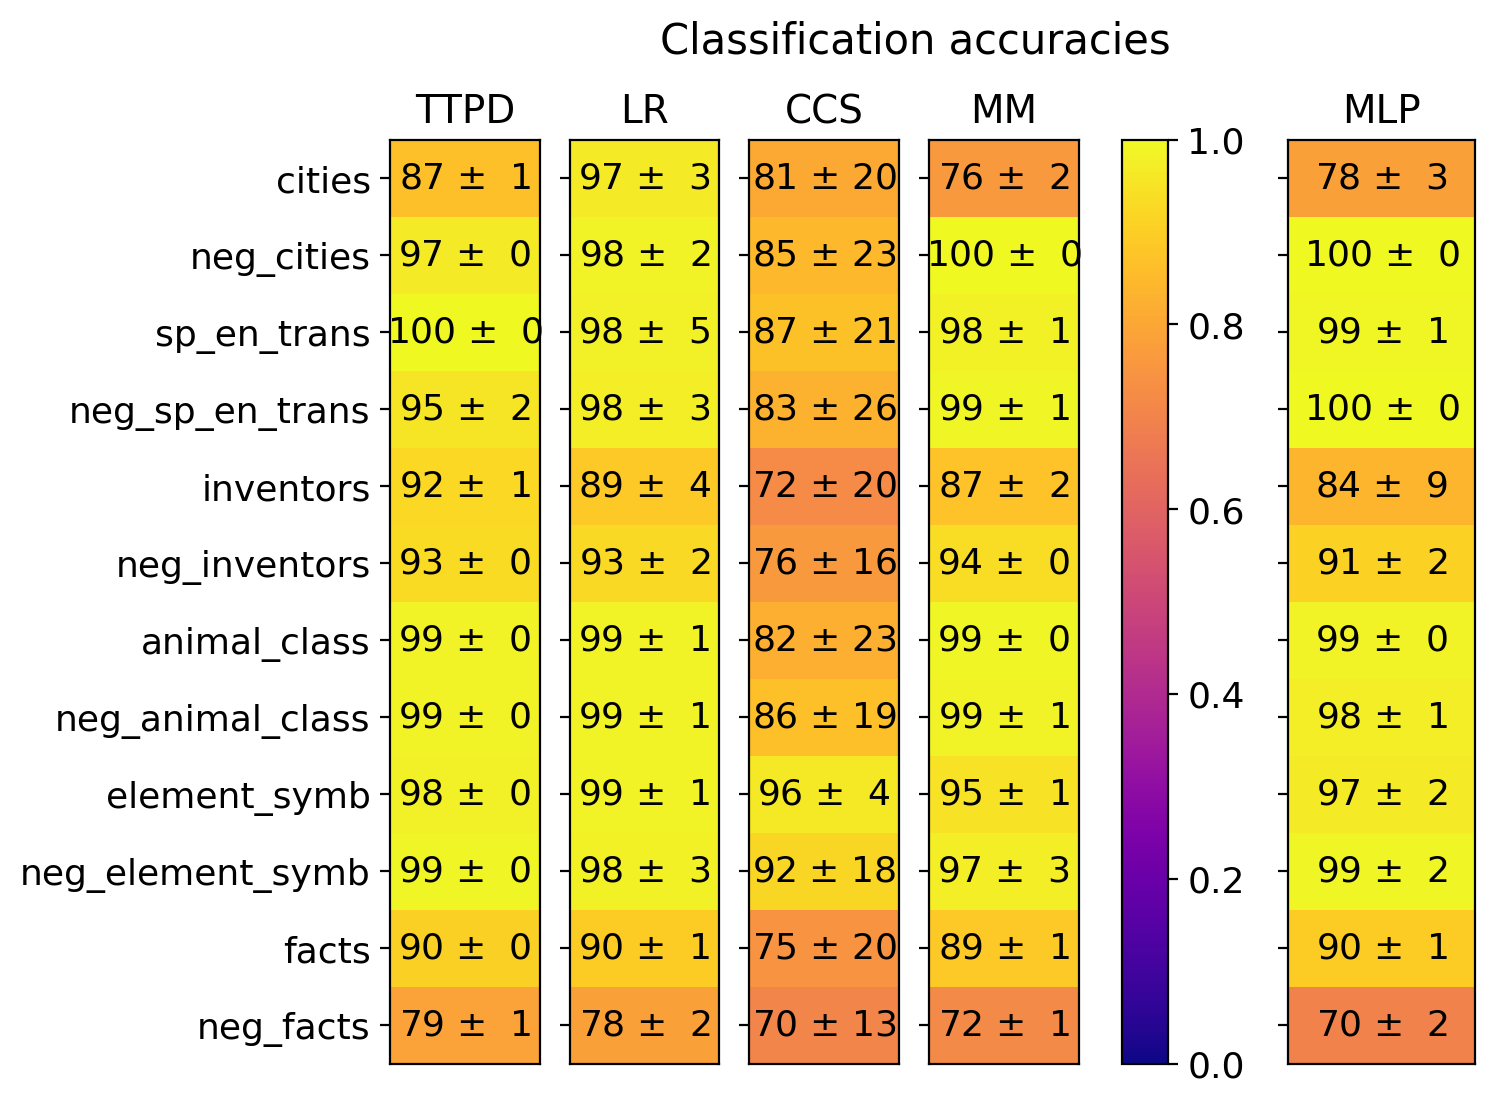

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(7, 6), ncols=5)
titles = ["TTPD", "LR", "CCS", "MM", "MLP"]

for t, (ax, key) in enumerate(zip((ax1, ax2, ax3, ax4, ax5), (TTPD, LRProbe, CCSProbe, MMProbe, SimpleMLPProbe))):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in train_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in train_sets]
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    for i, row in enumerate(grid):
        for j, val in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}', ha='center', va='center', fontsize=13)
    
    ax.set_yticks(range(len(train_sets)))
    ax.set_xticks([])
    
    ax.set_title(titles[t], fontsize=14)

ax1.set_yticklabels(train_sets, fontsize=13)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])

cbar = fig.colorbar(im, ax=[ax1, ax2, ax3, ax4, ax5])
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification accuracies", fontsize=15)

plt.savefig(f"./results/lie_detection--unseen_topics--{model_name}.svg", 
            bbox_inches = "tight")

### Generalization to logical conjunctions and disjunctions

In [10]:
# compare all probes on logical conjunctions and disjunctions
val_sets = ["cities_conj", "cities_disj", "sp_en_trans_conj","sp_en_trans_disj",
             "inventors_conj", "inventors_disj", "animal_class_conj", "animal_class_disj",
               "element_symb_conj", "element_symb_disj", "facts_conj", "facts_disj",
            "common_claim_true_false", "counterfact_true_false"]


probe_types = [SimpleMLPProbe, TTPD, LRProbe, CCSProbe, MMProbe]
results = { 
    SimpleMLPProbe: defaultdict(list),
    TTPD: defaultdict(list), 
    LRProbe: defaultdict(list), 
    CCSProbe: defaultdict(list), 
    MMProbe: defaultdict(list),
}
num_iter = 20
total_iterations = len(probe_types) * num_iter

with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size,
                                                                             model_type, layer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)
            if probe_type == SimpleMLPProbe:
                probe = SimpleMLPProbe.from_data(acts, labels, polarities)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_type == CCSProbe:
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                results[probe_type][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

Training and evaluating classifiers: 100%|██████████| 100/100 [04:08<00:00,  2.49s/it]


In [11]:
show_and_save_results(probe_accuracies, stat_results, "logical_junctions")

SimpleMLPProbe:
  Mean Accuracy: 73.46%
  Standard Deviation of the mean accuracy: 2.06%
TTPD:
  Mean Accuracy: 75.24%
  Standard Deviation of the mean accuracy: 0.32%
LRProbe:
  Mean Accuracy: 71.19%
  Standard Deviation of the mean accuracy: 1.25%
CCSProbe:
  Mean Accuracy: 69.52%
  Standard Deviation of the mean accuracy: 9.46%
MMProbe:
  Mean Accuracy: 74.42%
  Standard Deviation of the mean accuracy: 0.34%


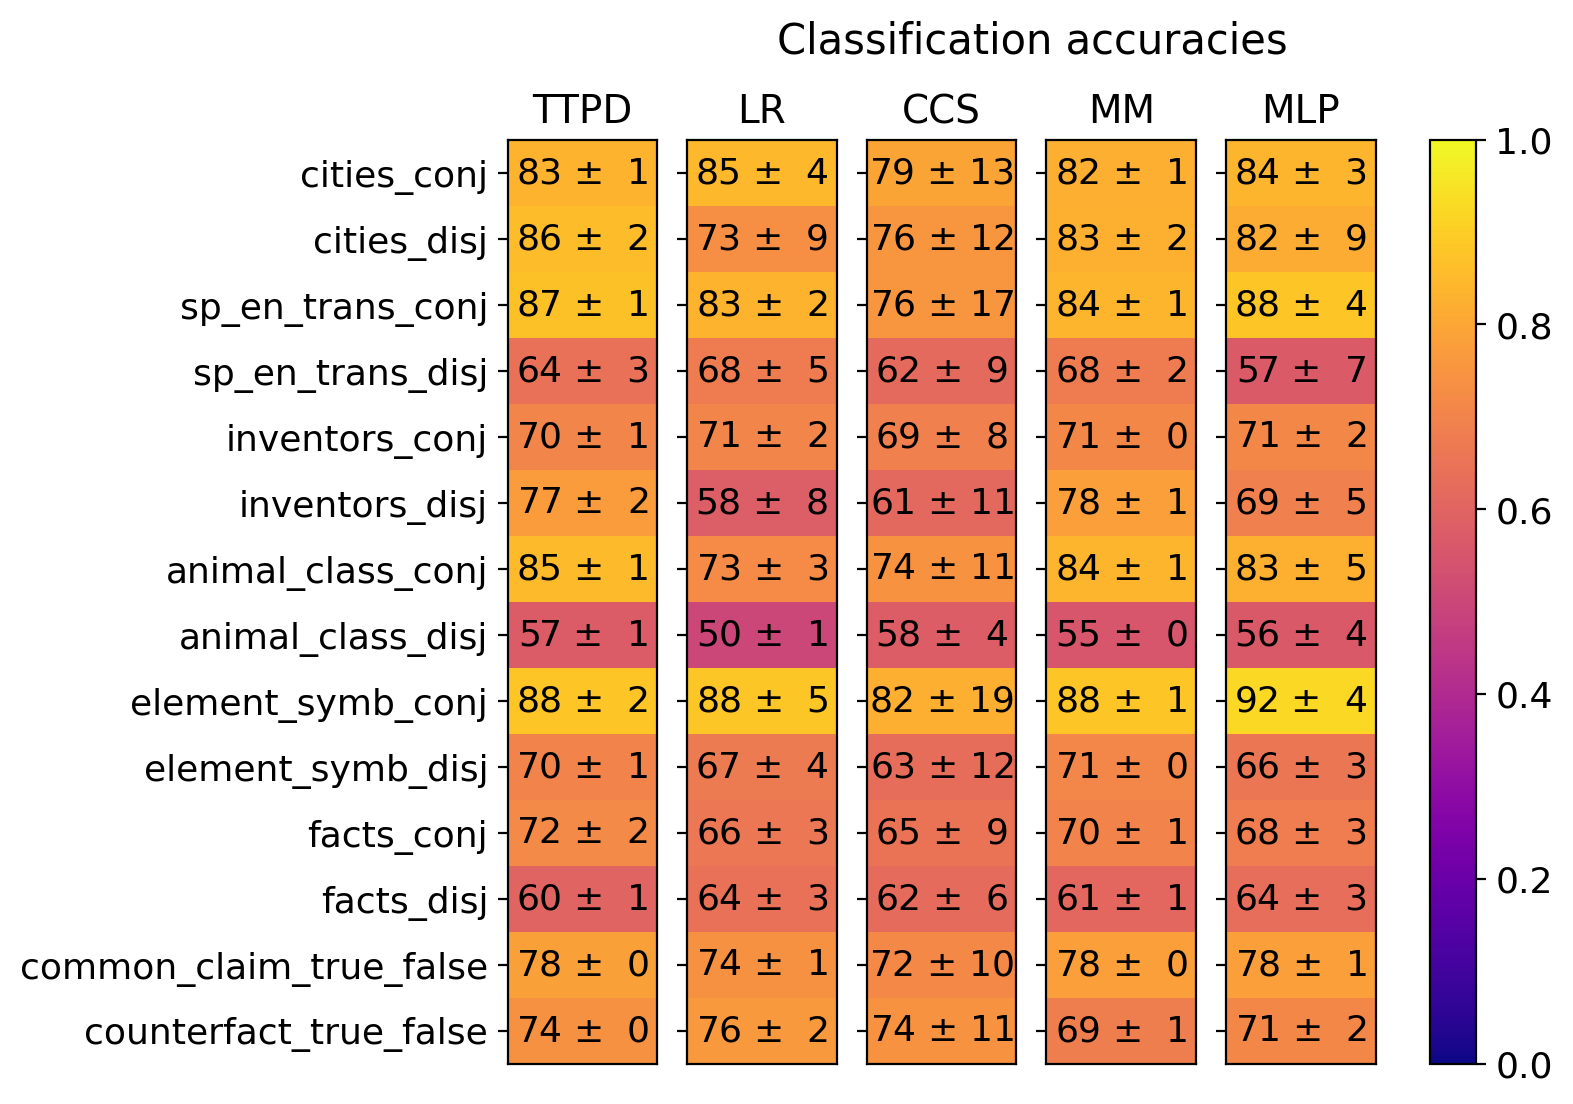

In [12]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(7, 6), ncols=5)
titles = ["TTPD", "LR", "CCS", "MM", "MLP"]

for t, (ax, key) in enumerate(zip((ax1, ax2, ax3, ax4, ax5), (TTPD, LRProbe, CCSProbe, MMProbe, SimpleMLPProbe))):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in val_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in val_sets]
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    for i, row in enumerate(grid):
        for j, val in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}', ha='center', va='center', fontsize=13)
    
    ax.set_yticks(range(len(val_sets)))
    ax.set_xticks([])
    
    ax.set_title(titles[t], fontsize=14)

ax1.set_yticklabels(val_sets, fontsize=13)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])

cbar = fig.colorbar(im, ax=[ax1, ax2, ax3, ax4, ax5])
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification accuracies", fontsize=15)

plt.savefig(f"./results/lie_detection--logical_junctions--{model_name}.svg", 
            bbox_inches = "tight")

### Generalization to German statements
Compare all probes on statements translated to German.

In [45]:
# Experiment hyperparameters
experiment_name = "german"
validation_type = "separate validation sets"
val_sets = [
    "cities_de", "neg_cities_de", 
    "sp_en_trans_de", "neg_sp_en_trans_de", 
    "inventors_de", "neg_inventors_de", 
    "animal_class_de", "neg_animal_class_de", 
    "element_symb_de", "neg_element_symb_de", 
    "facts_de", "neg_facts_de"
]   # len = 12
num_iter = 20   # number of times the probes are trained and evaluated on the same datasets

results = {f"{probe.__name__}":defaultdict(list) for probe in probe_types}   # create an empty dictionary to store the results for each probe type
total_iterations = len(probe_types) * num_iter

In [46]:
# Training and evaluating classifiers
    # Iterate over each probe type and number of iterations
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_name in probe_names:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size, model_type, layer)
            
            # train classifier
            if probe_name == "TTPD":
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_name == "LRProbe":
                probe = LRProbe.from_data(acts, labels)
            if probe_name == "CCSProbe":
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_name == "MMProbe":
                probe = MMProbe.from_data(acts, labels)
            if probe_name == "SimpleMLPProbe":
                probe = SimpleMLPProbe.from_data(acts, labels, polarities)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_name == "CCSProbe":
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                
                results[f"{probe_name}"][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

Training and evaluating classifiers: 100%|██████████| 100/100 [02:58<00:00,  1.79s/it]


#### Save and plot the results

##### Compute statistics for the results

In [84]:
probe_accuracies = compute_average_accuracies(results, num_iter)   # overall accuracies for each probe type
dataset_accuracies = compute_statistics(results)  # accuracies for each probe type and validation dataset
meta_info = {
    'notebook_name': notebook_name,
    'model_name': model_name,
    'layer': layer,
    'experiment_name': experiment_name,
    'probe_names': probe_names,
    'validation_type': validation_type,
    'num_iterations': num_iter,
    'train_sets': train_sets,
    'val_sets': val_sets,    
}   # Create a dictionary with meta information

show_and_save_results(probe_accuracies, dataset_accuracies, meta_info, save=True)

Results for the experiment 'german' and the model 'Llama3_8B_chat' (layer 12):
    mean accuracy ± std deviation
------------------------------------
SimpleMLPProbe      : 83.1 ±  7.8%
TTPD                : 87.5 ±  0.4%
LRProbe             : 89.8 ±  1.4%
CCSProbe            : 73.0 ± 18.3%
MMProbe             : 82.9 ±  1.1%
------------------------------------

Results saved to ./results/lie_detection--german--Llama3_8B_chat.json


##### Plot a grid of accuracies for each probe type and validation dataset.

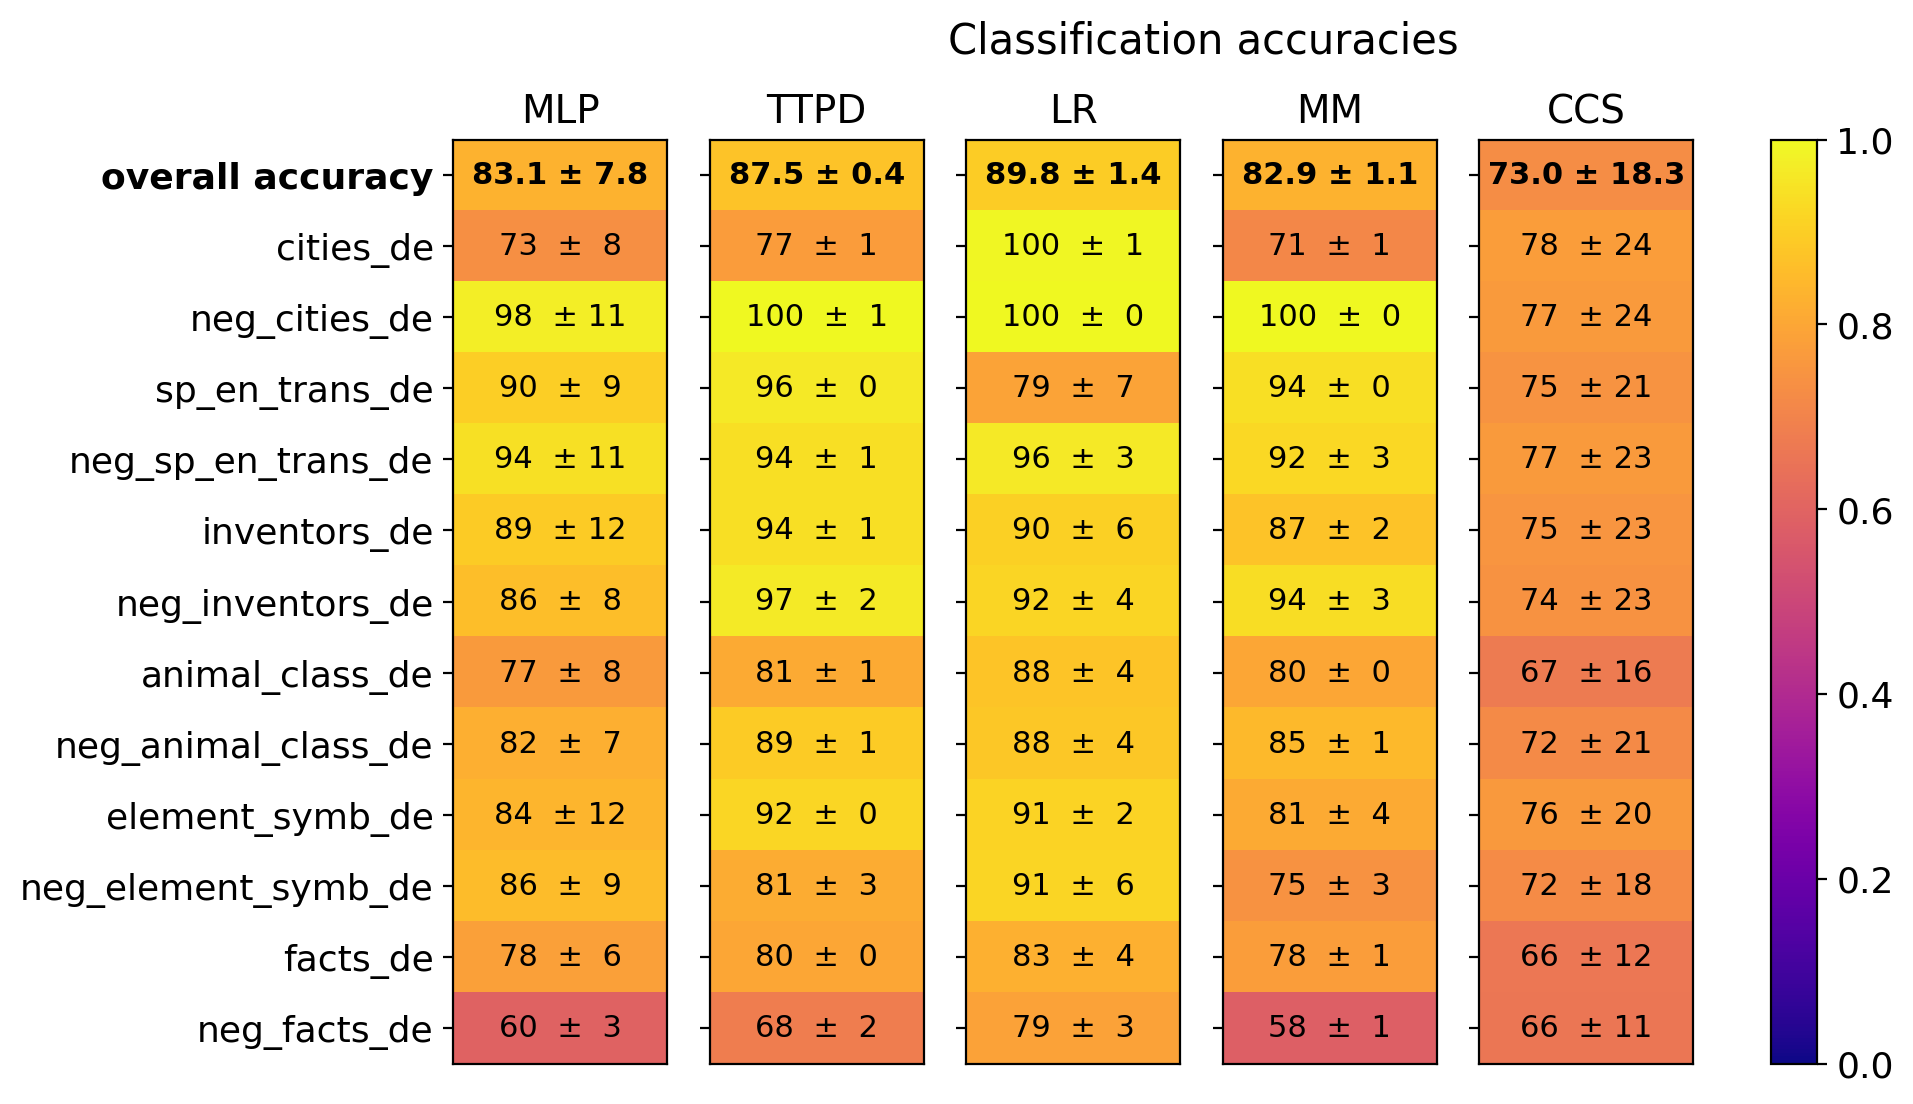

In [85]:
fig, axes = plt.subplots(figsize=(10, 6), ncols=len(probe_names))
fig.suptitle("Classification accuracies", fontsize=15)

# build the overall‐accuracy lists once
overall_means = [probe_accuracies[probe]['mean'] for probe in probe_names]
overall_stds  = [probe_accuracies[probe]['std_dev']  for probe in probe_names]

for t, (ax, key) in enumerate(zip(axes, probe_names)):
    # build the per‐dataset grid
    grid = [[dataset_accuracies[key]['mean'][dataset]] for dataset in val_sets]
    grid_std = [[dataset_accuracies[key]['std'][dataset]] for dataset in val_sets]
    
    # insert the "overall" row at the top
    grid.insert(0, [overall_means[t]])
    grid_std.insert(0, [overall_stds[t]])

    # draw it
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    # annotate
    for i, row in enumerate(grid):
        for j in range(len(row)):
            val = grid[i][j]
            std = grid_std[i][j]
            if i == 0:
                text = f"{val*100:3.1f} ± {std*100:3.1f}"
                weight = 'bold'
            else:
                text = f"{val*100:2.0f}  ± {std*100:2.0f}"
                weight = 'normal'
            ax.text(j, i, text, ha='center', va='center', fontsize=11, fontweight=weight)
    
    # ticks and titles
    ax.set_title(probe_names_short[t], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks(range(len(grid)))
    ax.set_yticklabels([])

# label the y‐axis on the first column only
yticks = ["overall accuracy"] + val_sets
axes[0].set_yticklabels(yticks, fontsize=13)
for label in axes[0].get_yticklabels():
    if label.get_text() == "overall accuracy":
        label.set_fontweight("bold")
    else:
        label.set_fontweight("normal")

# colorbar
cbar = fig.colorbar(im, ax=axes)
cbar.ax.tick_params(labelsize=13)

# save the figure
plt.savefig(f"./results/{notebook_name}--{experiment_name}--{model_name}.svg", bbox_inches = "tight")

### Displaying generalization to Conjunctions, Disjunctions and German statements in one table

In [16]:
# Define the validation sets and the probe types
val_sets = ["cities_conj", "cities_disj", "sp_en_trans_conj","sp_en_trans_disj",
             "inventors_conj", "inventors_disj", "animal_class_conj", "animal_class_disj",
               "element_symb_conj", "element_symb_disj", "facts_conj", "facts_disj", "cities_de", "neg_cities_de", "sp_en_trans_de", "neg_sp_en_trans_de", "inventors_de", "neg_inventors_de", "animal_class_de",
                  "neg_animal_class_de", "element_symb_de", "neg_element_symb_de", "facts_de", "neg_facts_de",
            "common_claim_true_false", "counterfact_true_false"]

probe_types = [SimpleMLPProbe, TTPD, LRProbe, CCSProbe, MMProbe]
results = {
    SimpleMLPProbe: defaultdict(list),
    TTPD: defaultdict(list), 
    LRProbe: defaultdict(list), 
    CCSProbe: defaultdict(list), 
    MMProbe: defaultdict(list),
}
num_iter = 20
total_iterations = len(probe_types) * num_iter

# Training and evaluating classifiers
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar:
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family, model_size,
                                                                                           model_type, layer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)
            if probe_type == SimpleMLPProbe:
                probe = SimpleMLPProbe.from_data(acts, labels, polarities)

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_type == CCSProbe:
                    acts = acts - (mean_affirm + mean_neg)/2
                predictions = probe.pred(acts)
                results[probe_type][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

Training and evaluating classifiers: 100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


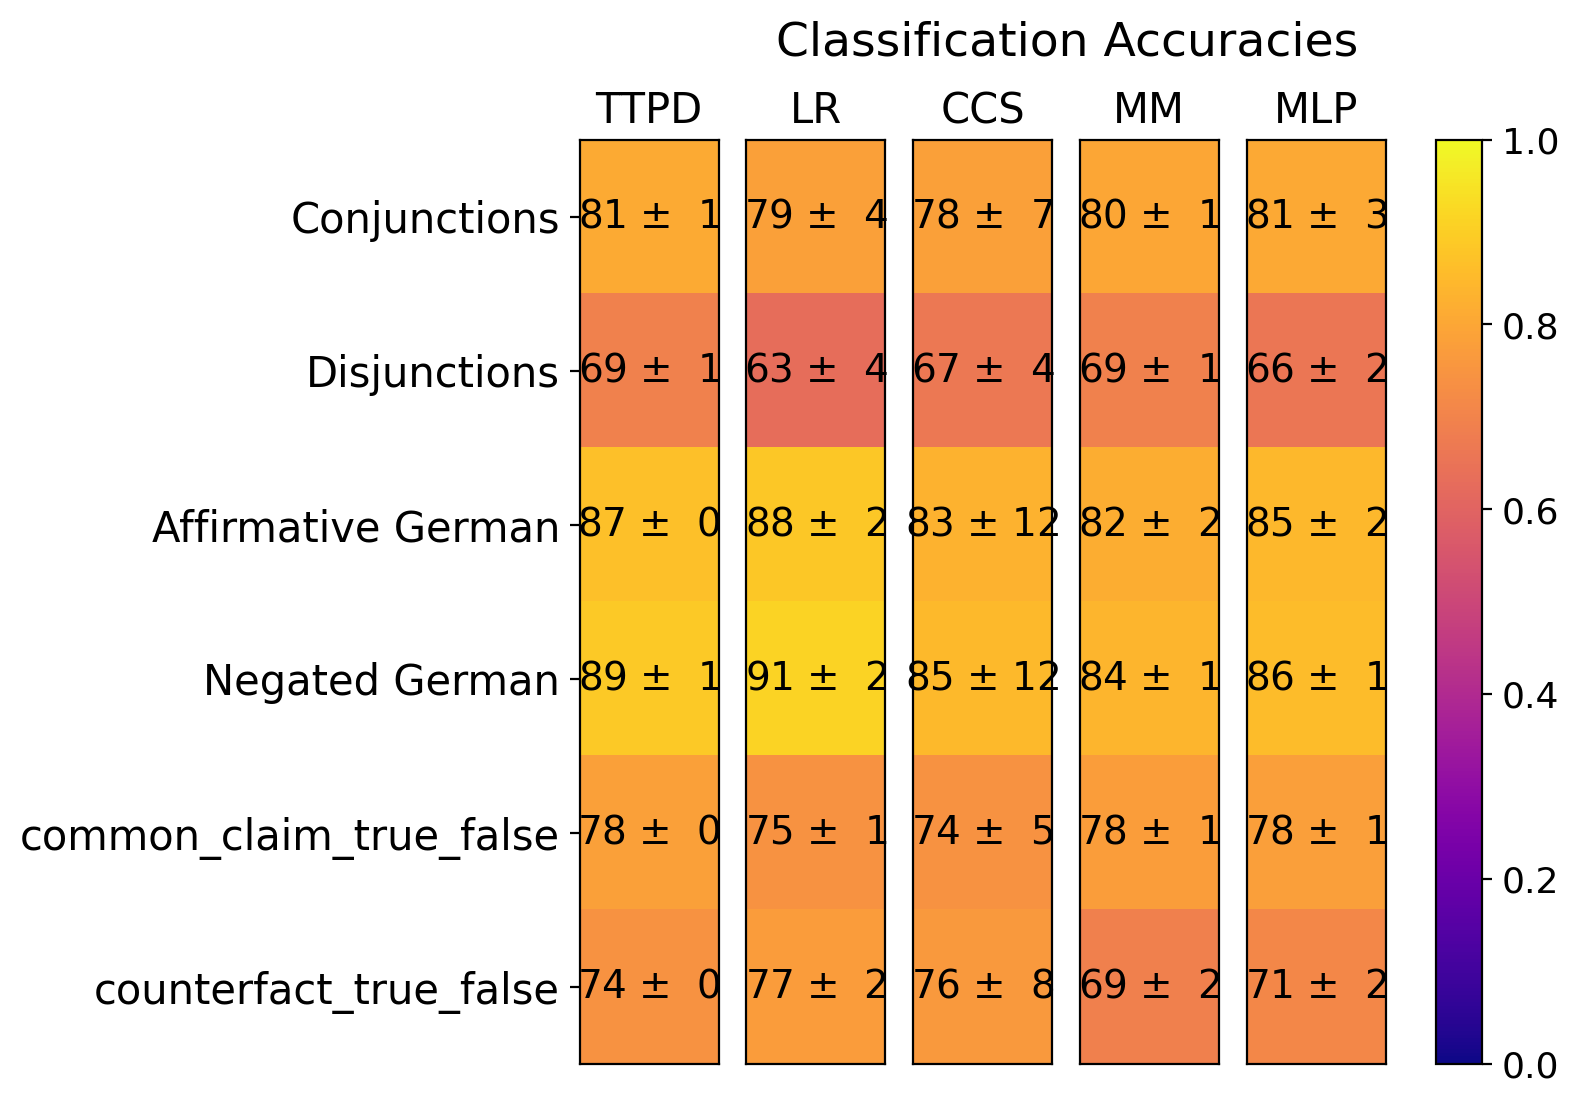

In [18]:
# Define the groups
groups = {
    'Conjunctions': [dataset for dataset in val_sets if dataset.endswith('_conj')],
    'Disjunctions': [dataset for dataset in val_sets if dataset.endswith('_disj')],
    'Affirmative German': [dataset for dataset in val_sets if dataset.endswith('_de') and not dataset.startswith('neg_')],
    'Negated German': [dataset for dataset in val_sets if dataset.startswith('neg_') and dataset.endswith('_de')],
    'common_claim_true_false': ['common_claim_true_false'],
    'counterfact_true_false': ['counterfact_true_false']
}

# Initialize group results
group_results = {probe_type: {group_name: [] for group_name in groups} for probe_type in probe_types}

# Process results to compute mean accuracies per group per classifier
for probe_type in probe_types:
    for n in range(num_iter):
        for group_name, group_datasets in groups.items():
            accuracies = []
            for dataset in group_datasets:
                accuracy = results[probe_type][dataset][n]
                accuracies.append(accuracy)
            mean_accuracy = sum(accuracies) / len(accuracies)
            group_results[probe_type][group_name].append(mean_accuracy)

# Compute statistics
stat_group_results = {probe_type: {'mean': {}, 'std': {}} for probe_type in probe_types}

for probe_type in probe_types:
    for group_name in groups:
        accuracies = group_results[probe_type][group_name]
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)
        stat_group_results[probe_type]['mean'][group_name] = mean_accuracy
        stat_group_results[probe_type]['std'][group_name] = std_accuracy

# Map probe types to classifier names
probe_type_to_name = {
    TTPD: 'TTPD',
    LRProbe: 'LR',
    CCSProbe: 'CCS',
    MMProbe: 'MM',
    SimpleMLPProbe: 'MLP',
}

# Create DataFrames for mean accuracies and standard deviations
group_names = ['Conjunctions', 'Disjunctions', 'Affirmative German', 'Negated German', 'common_claim_true_false', 'counterfact_true_false']
classifier_names = ['TTPD', 'LR', 'CCS', 'MM', 'MLP']

mean_df = pd.DataFrame(index=group_names, columns=classifier_names)
std_df = pd.DataFrame(index=group_names, columns=classifier_names)

for probe_type in probe_types:
    classifier_name = probe_type_to_name[probe_type]
    for group_name in group_names:
        mean_accuracy = stat_group_results[probe_type]['mean'][group_name]
        std_accuracy = stat_group_results[probe_type]['std'][group_name]
        mean_df.loc[group_name, classifier_name] = mean_accuracy
        std_df.loc[group_name, classifier_name] = std_accuracy

fig, axes = plt.subplots(figsize=(6.5, 6), ncols=5)

for idx, classifier_name in enumerate(classifier_names):
    ax = axes[idx]
    mean_values = mean_df[classifier_name].values.astype(float)
    std_values = std_df[classifier_name].values.astype(float)
    
    # Create heatmap
    im = ax.imshow(mean_values[:, np.newaxis], vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    # Annotate the heatmap with mean accuracies and standard deviations
    for i in range(len(group_names)):
        mean_accuracy = mean_values[i]
        std_accuracy = std_values[i]
        ax.text(0, i, f'{round(mean_accuracy * 100):2d} $\pm$ {round(std_accuracy * 100):2d}', ha='center', va='center', fontsize=14)
    
    # Set ticks and labels
    ax.set_xticks([])
    if idx == 0:
        ax.set_yticks(np.arange(len(group_names)))
        ax.set_yticklabels(group_names, fontsize=15)
    else:
        ax.set_yticks([])
    ax.set_title(classifier_name, fontsize=15)

# Add colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist())
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification Accuracies", fontsize=17)

plt.savefig(f"./results/lie_detection--overall_generalization--{model_name}.svg", 
            bbox_inches = "tight")

### Real world scenarios / lies

In [20]:
probe_types = [SimpleMLPProbe, TTPD, LRProbe, CCSProbe, MMProbe]
results = {
    SimpleMLPProbe: [], 
    TTPD: [], 
    LRProbe: [], 
    CCSProbe: [], 
    MMProbe: []}
num_iter = 50

total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities = collect_training_data(train_sets, train_set_sizes, model_family,
                                                                                           model_size, model_type,layer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')
            if probe_type == MMProbe:
                probe = MMProbe.from_data(acts, labels)
            if probe_type == SimpleMLPProbe:
                probe = SimpleMLPProbe.from_data(acts, labels, polarities)

            # evaluate classification accuracy on real world scenarios
            dm = DataManager()
            real_world_dataset = "real_world_scenarios/all_unambiguous_replies"
            dm.add_dataset(real_world_dataset, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
            acts, labels = dm.data[real_world_dataset]
            
            # classifier specific predictions
            if probe_type == CCSProbe:
                acts = acts - (mean_affirm + mean_neg)/2

            predictions = probe.pred(acts)
            results[probe_type].append((predictions == labels).float().mean().item())
            pbar.update(1)

Training and evaluating classifiers: 100%|██████████| 250/250 [05:58<00:00,  1.43s/it]


In [21]:
# Show and save classifier accuracies
result_lines = []
for probe_type in probe_types:
    mean = np.mean(results[probe_type])
    std = np.std(results[probe_type])
    result_lines.append(f"{probe_type.__name__}:")
    result_lines.append(f"  Mean Accuracy: {mean*100:.2f}%")
    result_lines.append(f"  Standard Deviation: {std*100:.2f}%")
result_str = "\n".join(result_lines)

print(result_str)
with open(f"./results/lie_detection--real_world_lies--{model_name}.txt", "w") as f:
    f.write(result_str)

SimpleMLPProbe:
  Mean Accuracy: 88.10%
  Standard Deviation: 7.06%
TTPD:
  Mean Accuracy: 93.58%
  Standard Deviation: 1.28%
LRProbe:
  Mean Accuracy: 77.40%
  Standard Deviation: 8.81%
CCSProbe:
  Mean Accuracy: 71.73%
  Standard Deviation: 12.42%
MMProbe:
  Mean Accuracy: 90.85%
  Standard Deviation: 1.36%
